Copyright Rigetti Computing 2021.

## Digital Zero Noise Extrapolation using PyQuil

In this notebook, we'll explore the technique of using digital zero noise extrapolation to mitigate for gate errors. Specifically, we'll use the depolarizing channel as our noise model.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import itertools

import numpy as np

from pyquil import get_qc, Program
from pyquil.gates import *
from pyquil.paulis import *

from tqdm import tqdm

import networkx as nx

import functools

We'll first define some handy functions that will aid us in our analysis.

In [2]:
def random_unitary(n):
    """
    :param n: number of qubits
    :return: array of shape (2^n, 2^n) representing random unitary matrix drawn from Haar measure
    """
    # draw complex matrix from Ginibre ensemble
    z = np.random.randn(2**n, 2**n) + 1j * np.random.randn(2**n, 2**n)
    # QR decompose this complex matrix
    q, r = np.linalg.qr(z)
    # make this decomposition unique
    d = np.diagonal(r)
    l = np.diag(d) / np.abs(d)
    return np.matmul(q, l)

In [3]:
def pauli_operators(n):
    """
    Generates all 4^n Pauli operators over n qubits
    
    :param n: number of qubits
    :return: list of arrays, each array of shape (2^n, 2^n) representing a Pauli operator
    """
    # list single qubit Pauli operators
    sI = np.array([[1, 0], [0, 1]])
    sX = np.array([[0, 1], [1, 0]])
    sY = np.array([[0, -1j], [1j, 0]])
    sZ = np.array([[1, 0], [0, -1]])
    paulis = [sI, sX, sY, sZ]
   
    # identify the dimension of the Hilbert space
    dim = 2**n

    ## Sanity check -- initialize an arbitrary initial state
    ##       and make sure it gets sent to totally mixed state
    ket = np.random.uniform(0.0, 1.0, size=dim)
    ket /= np.sqrt(np.sum(ket**2))
    assert np.isclose(np.sum(ket**2), 1.0)  # normalize

    rho = np.outer(ket, ket)

    rho_pr = np.zeros((dim, dim), dtype='complex128')
    
    ops_list = []

    for x in itertools.product(paulis, repeat=n):
        op = functools.reduce(lambda a, b: np.kron(a, b), x)
        assert np.allclose(op @ op.conj().T, np.eye(2**n)), f"op**2: {op @ op.conj().T}"
        rho_pr += op @ rho @ op.conj().T
        ops_list.append(op)

    assert np.allclose(rho_pr / (dim**2), np.eye(dim)/dim)
    
    # return the desired list of operators
    return ops_list

In [4]:
def depolarizing_kraus_ops(prob, n=2):
    """
    Provides the Kraus operators for a depolarizing channel over `n_qubits`
    
    :param prob: probability of obtaining maximally mixed state
    :param n: number of qubits
    :return: list of arrays, each array of shape (2^n, 2^n) representing a Kraus operator
    """
    I_ = np.eye(2**n)
    D_ops = pauli_operators(n)
    kraus_ops = [np.sqrt(1-prob) * I_]
    for D_ in D_ops:
        kraus_ops.append(np.sqrt(prob/len(D_ops)) * D_)
    return kraus_ops

We'll investigate the case of a circuit preparing a Bell state $\frac{1}{\sqrt{2}} \left( \vert 00 \rangle + \vert 11 \rangle \right)$. We would like to compute the expectation value of the observable $ZZ$ in this state. Since $\langle 00 \vert ZZ \vert 00 \rangle = \langle 11 \vert ZZ \vert 11 \rangle = 1$ and $\langle 00 \vert ZZ \vert 11 \rangle = \langle 11 \vert ZZ \vert 00 \rangle = 0$, we expect to find $\langle Z \rangle = 1$ in this state.

In [5]:
qc = get_qc('2q-qvm')

n_shots = 10_000

# write Bell circuit prep program
prog = Program()
ro = prog.declare('ro', 'BIT', 2)
# Note: Pragma preservation makes sure gates stay intact,
#    and are not "compiled" away
prog += Program("PRAGMA PRESERVE_BLOCK")
prog += H(0)
prog += CNOT(0, 1)
prog += Program("PRAGMA END_PRESERVE_BLOCK")

for idx, q in enumerate([0, 1]):
    prog += MEASURE(q, ro[idx])

prog.wrap_in_numshots_loop(n_shots)

results = qc.run(prog)

ZZ_eigs = 1 - 2*results

ZZ = np.mean(ZZ_eigs[:,0] * ZZ_eigs[:,1])

print(ZZ)  # should be 1.0

1.0


Next, let's add some depolarizing noise. In pyQuil, we can do this by first defining a dummy gate, then over-writing this dummy gate with the depolarizing channel. We'll follow every use of a `CNOT` with this noisy gate, so that in effect our CNOTs become 2-qubit depolarizing channels where with some probability we obtain the state unitarily evolving through a `CNOT` gate, and with remaining probability we get the totally mixed state.

In [6]:
qc = get_qc('2q-qvm')

n_shots = 10_000

# specify error probability
gate_fidelity = 0.80
prob = 1 - gate_fidelity

# write noisy program
prog = Program()
ro = prog.declare('ro', 'BIT', 2)
prog.defgate("DummyGate", random_unitary(2))
prog.define_noisy_gate("DummyGate", [0, 1], depolarizing_kraus_ops(prob))
    
p_noisy = prog.copy()
p_noisy += Program("PRAGMA PRESERVE_BLOCK")
p_noisy += H(0)
p_noisy += CNOT(0, 1)
p_noisy += [("DummyGate", 0, 1)]
p_noisy += Program("PRAGMA END_PRESERVE_BLOCK")

for idx, q in enumerate([0, 1]):
    p_noisy += MEASURE(q, ro[idx])

p_noisy.wrap_in_numshots_loop(n_shots)

results = qc.run(p_noisy)

ZZ_eigs = 1 - 2*results

ZZ = np.mean(ZZ_eigs[:,0] * ZZ_eigs[:,1])

print(ZZ)  # should be approx. 0.8

0.7926


In order to exaggerate the noise in the system, we can similarly apply 3 noisy CNOTs.

In [7]:
qc = get_qc('2q-qvm')

n_shots = 10_000

n_noisy = 3   # no. of noisy 2q gate

# specify error probability
gate_fidelity = 0.80
prob = 1 - gate_fidelity

# write noisy program
prog = Program()
ro = prog.declare('ro', 'BIT', 2)
prog.defgate("DummyGate", random_unitary(2))
prog.define_noisy_gate("DummyGate", [0, 1], depolarizing_kraus_ops(prob))
    
p_noisy = prog.copy()
p_noisy += Program("PRAGMA PRESERVE_BLOCK")
p_noisy += H(0)
for _ in range(n_noisy):
    p_noisy += CNOT(0, 1)
    p_noisy += [("DummyGate", 0, 1)]
p_noisy += Program("PRAGMA END_PRESERVE_BLOCK")

for idx, q in enumerate([0, 1]):
    p_noisy += MEASURE(q, ro[idx])

p_noisy.wrap_in_numshots_loop(n_shots)

results = qc.run(p_noisy)

ZZ_eigs = 1 - 2*results

ZZ = np.mean(ZZ_eigs[:,0] * ZZ_eigs[:,1])

print(ZZ)  # should be approx. 0.8^3 ~ 0.512

0.5098


Next, we use the digital zero noise extrapolation technique, as described in the lecture, to compute the ideal expectation value as well as the depolarizing noise on the system.

We'll compute the noisy estimates of the expectation values at several values of the no. of (noisy) CNOTs we have in the circuit.

In [8]:
qc = get_qc('2q-qvm')

n_shots = 10_000

# specify error probability
gate_fidelity = 0.80
prob = 1 - gate_fidelity

# collect ZZ estimates for several number of noisy CNOTs
ZZ_vals = []
n_noisy = [1, 3, 5, 7, 9, 11, 13, 15]

# write noisy program
prog = Program()
ro = prog.declare('ro', 'BIT', 2)
prog.defgate("DummyGate", random_unitary(2))
prog.define_noisy_gate("DummyGate", [0, 1], depolarizing_kraus_ops(prob))

for n_cnots in tqdm(n_noisy):
    
    p_noisy = prog.copy()
    p_noisy += Program("PRAGMA PRESERVE_BLOCK")
    p_noisy += H(0)
    for _ in range(n_cnots):
        p_noisy += CNOT(0, 1)
        p_noisy += [("DummyGate", 0, 1)]
    p_noisy += Program("PRAGMA END_PRESERVE_BLOCK")
    
    for idx, q in enumerate([0, 1]):
        p_noisy += MEASURE(q, ro[idx])
        
    p_noisy.wrap_in_numshots_loop(n_shots)
    
    results = qc.run(p_noisy)
    
    ZZ_eigs = 1 - 2*results

    ZZ = np.mean(ZZ_eigs[:,0] * ZZ_eigs[:,1])
    
    ZZ_vals.append(ZZ)

100%|██████████| 8/8 [00:23<00:00,  2.94s/it]


Check that the results make sense by comparing against the theoretical value.

In [9]:
for idx, n in enumerate(n_noisy):
    print(f"n: {n}")
    expt = ZZ_vals[idx]
    theory = gate_fidelity**n
    print(f"expt ZZ-val: {expt}")
    print(f"theory ZZ-val: {theory}")

    # Ideally, we should check for numerical closeness.
    # At this no. of shots, this check can sometimes fail.
    #     assert np.isclose(theory, expt, atol=1e-2)
    print("*" * 30)

n: 1
expt ZZ-val: 0.8072
theory ZZ-val: 0.8
******************************
n: 3
expt ZZ-val: 0.5032
theory ZZ-val: 0.5120000000000001
******************************
n: 5
expt ZZ-val: 0.3096
theory ZZ-val: 0.3276800000000001
******************************
n: 7
expt ZZ-val: 0.2138
theory ZZ-val: 0.20971520000000007
******************************
n: 9
expt ZZ-val: 0.125
theory ZZ-val: 0.13421772800000006
******************************
n: 11
expt ZZ-val: 0.0972
theory ZZ-val: 0.08589934592000005
******************************
n: 13
expt ZZ-val: 0.0416
theory ZZ-val: 0.054975581388800036
******************************
n: 15
expt ZZ-val: 0.0314
theory ZZ-val: 0.03518437208883203
******************************


Let's generate a plot of expectation values vs. no. of noisy CNOTs to convince ourselves it looks like a straight line. Recall that for the depolarizing noise channel, we expect the noisy expectation values to behave as $y = Cp^n \Rightarrow \log{y} = n \log{p} + \log{C}$, where $y$ denotes the noisy expectation values we have measured, $n$ is the no. of noisy `CNOT` gates we have applied, $p$ is the gate fidelity, and $C$ is the ideal expectation value.

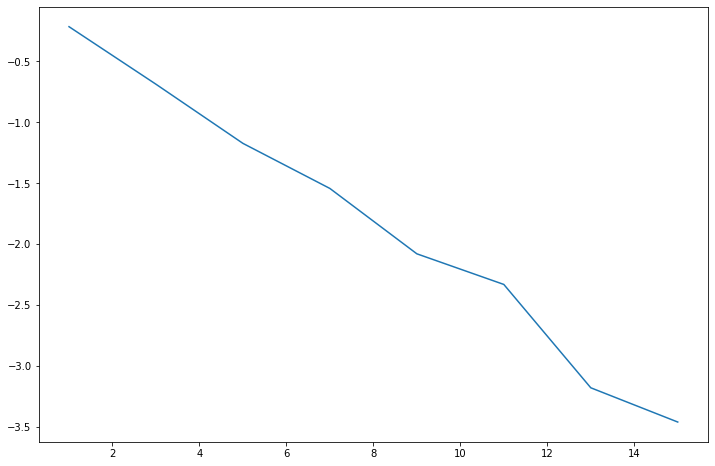

In [10]:
n_noisy = np.array(n_noisy)
ZZ_vals = np.array(ZZ_vals)

x_vals = n_noisy
y_vals = np.log(ZZ_vals)

plt.figure(figsize=(12, 8))
plt.plot(x_vals, y_vals)
plt.show()

Next, let's fit a straight line model to the above data. We can then extract the ideal expecation value using the formula described above.

In [11]:
from scipy.optimize import curve_fit

def linear_model(x, m, c):
    return m*x + c

popt, pcov = curve_fit(linear_model, x_vals, y_vals)

m, c = popt
print(f"exptl prob: {np.exp(m)}")   # should be close to 0.8
print(f"ideal expectation value: {np.exp(c)}")    # should be close to 1.0

exptl prob: 0.7918705174928765
ideal expectation value: 1.0340292432232288
